In [27]:
#!pip install pandas
#!pip install tabpfn
#!pip install mlxtend
#!pip install ipykernel
#!pip install autogluon
#!pip install scikit-learn
#!pip install imblearn
#!pip install numpy
#!pip install scikit-optimize
#!pip install import_ipynb
#!pip install ipywidgets
#!pip install jupyter_contrib_nbextensions
#!pip install darts
#!pip install optuna
#!pip install git+https://github.com/amazon-science/chronos-forecasting.git
#!pip install optuna-integration


In [1]:
from darts.models import NBEATSModel, LightGBMModel
import import_ipynb
import ts_fc_functions as ff
import ts_fc_chronos_functions as cf
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


importing Jupyter notebook from ts_fc_functions.ipynb
importing Jupyter notebook from ts_fc_chronos_functions.ipynb


In [2]:
# Step 0: Load CSV files
# Reference your CSV files with CRP-values and administered antibiotics here
crp = pd.read_csv("./PATH/YOUR_CRP_FILE.csv",sep=';')
ab_administered = pd.read_csv("./PATH/YOUR_MEDICATIONS_FILE.csv")
covariates = False

In [3]:
# Step 1: Data preprocessing
df_crp, df_ab_groups = ff.load_data_from_csv_and_merge_no_covars(crp,ab_administered)
data = ff.create_merge_no_covars(df_crp, df_ab_groups)
train_series_dict_full, train_series_covars_full,valid_series_dict_full,train_series_covars,resampled_df = ff.data_processing(data)


In [4]:
# Step 2: Load pretrained models

# Gradient Boosting - LightGBM models
lgbm_v1 = LightGBMModel.load("./models_prod/model_lgbm.pkl")
lgbm_v2 = LightGBMModel.load("./models_prod/best_model_lgbm.pkl")
# Deep Learning - NBeats models
nbeats_v1 = NBEATSModel.load("./models_prod/model_nbeats.pth.tar")
nbeats_v2 = NBEATSModel.load("./models_prod/best_model_nbeats_full.pth.tar")
# Weighted Ensemble of DL models - AutoGluonTS WeightedEnsemble
ensemble = TimeSeriesPredictor.load("./autogluon")
# Zero-shot large language model - Chronos


In [10]:
# Step 3: Perfrom CRP predictions and calculate metrics
# Set model type for which predictions should be performed
# [lgbm_v1,lgbm_v2,nbeats_v1,nbeats_v2,ensemble,chronos]
model = nbeats_v2

if model in (lgbm_v1,lgbm_v2,nbeats_v1,nbeats_v2):
    predicted_values, actual_values, keys, pred,pred_ci_down,pred_ci_up = ff.predict_proba(model,train_series_dict_full,valid_series_dict_full,covariates,train_series_covars)
elif model == ensemble:
    predictions, train_data, test_data, merged_data = ff.autogluon_data(resampled_df,model)
elif model == 'chronos':
    forecasts, valid_series_tensors = cf.chronos_predict(train_series_dict_full,valid_series_dict_full)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 1g.10gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 3.301683348180032
MSE: 23.060090368962264
RMSE: 4.802092290758504
MAPE: 30.621339866292875%
SMAPE: 14.108602801812594%


177


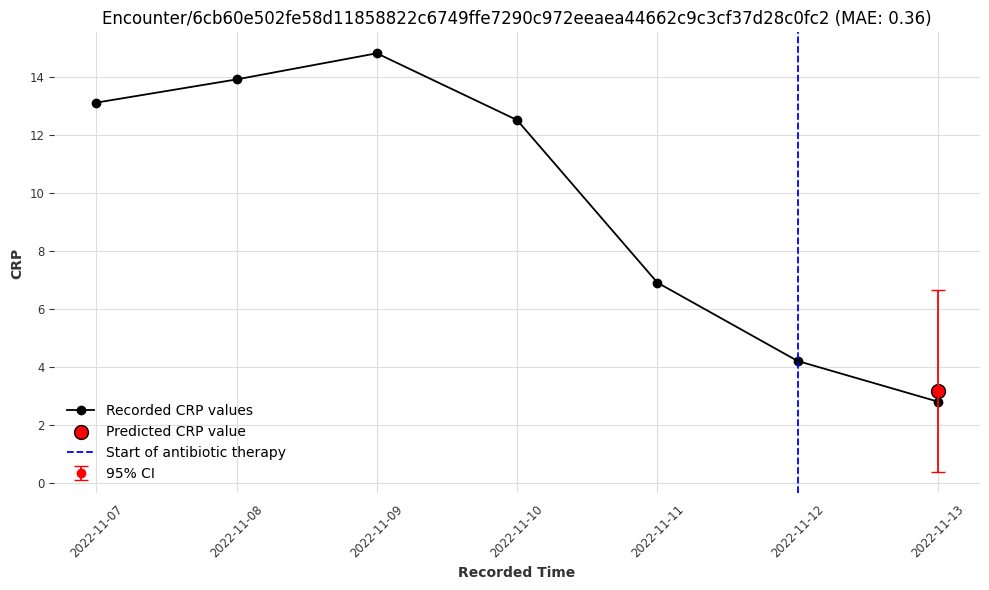

In [12]:
# Step 4: Visualize predictions
# Set an integer number for a fixed seed or None for a random seed
key_index = None

if model in (lgbm_v1,lgbm_v2,nbeats_v1,nbeats_v2):
    ff.plot_random_ts_proba(key_index, predicted_values, actual_values, keys, valid_series_dict_full, pred_ci_up, pred_ci_down)
elif model == ensemble:
    ff.plot_random_ts_proba_gluon(key_index,test_data, merged_data)
else:
    ff.plot_random_ts_proba(key_index, predicted_values, actual_values, keys, valid_series_dict_full, pred_ci_up, pred_ci_down)